### Video Analytics-Assignment 1
### Ashish Vashistha
#### 2024AA05043

### Setup & Imports

#### Install & imports

In [30]:
# Libraries to Install if not available
# !pip install opencv-python matplotlib numpy pandas scikit-learn torch torchvision tqdm seaborn

import os, time, json, math
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

### Problem Statement

✅ Objective

Develop a comparative video classification system that implements modern deep-learning approaches to categorize videos into predefined classes. The goal is not just to build one classifier, but to compare multiple approaches (e.g., 2D CNN + temporal pooling, 3D CNN, or pretrained video models) on the same dataset splits and report performance consistently.

We will compare two widely used deep learning models

*Model A — 2D CNN Frame Aggregation* 

- Sample T frames from each video
- Extract features/logits per frame using a pretrained ResNet-18
- Aggregate over time (mean pooling)
- Classify video

✅ Pros: fast, easy baseline

⚠️ Cons: limited temporal modeling

*Model B — 3D CNN Clip Model*

- Sample a clip of T frames
- Feed into pretrained R3D-18 (3D ResNet) from torchvision
- Classify video

✅ Pros: learns motion/temporal patterns

⚠️ Cons: heavier compute

### Dataset is arranged as per recommended instructions in Assignment

DATA_ROOT/

├─ class_1/

│  ├─ video_001.mp4

│  ├─ video_002.mp4

│  └─ ...

├─ class_2/

│  ├─ video_101.mp4

│  └─ ...

├─ ...

├─ splits/

│  ├─ train.txt

│  ├─ val.txt

│  └─ test.txt

├─ dataset_info.txt

└─ README.md

#### Configuration (Dataset Paths and Split Definition)

In [2]:
DATA_ROOT = r"Dataset_DL"
SPLITS_DIR = os.path.join(DATA_ROOT, "splits")

TRAIN_TXT = os.path.join(SPLITS_DIR, "train.txt")
VAL_TXT   = os.path.join(SPLITS_DIR, "val.txt")
TEST_TXT  = os.path.join(SPLITS_DIR, "test.txt")

IMG_SIZE = 224
VIDEO_EXTS = (".mp4", ".avi", ".mov", ".mkv")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


### Data Handling & Preprocessing

#### Dataset & Task (read split files, infer class count)

#### Read split files

In [3]:
def read_split_file(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            rel_path, label = line.split()
            rows.append((rel_path, int(label)))
    return rows

train_rows = read_split_file(TRAIN_TXT)
val_rows   = read_split_file(VAL_TXT)
test_rows  = read_split_file(TEST_TXT)

all_labels = [y for _, y in (train_rows + val_rows + test_rows)]
NUM_CLASSES = len(sorted(set(all_labels)))

print("Train/Val/Test sizes:", len(train_rows), len(val_rows), len(test_rows))
print("Num classes:", NUM_CLASSES)
print("Example row:", train_rows[7], val_rows[7], test_rows[7])

Train/Val/Test sizes: 277 59 60
Num classes: 3
Example row: ('CricketBowling/v_CricketBowling_g03_c03.avi', 1) ('WalkingWithDog/v_WalkingWithDog_g01_c04.avi', 2) ('CricketBowling/v_CricketBowling_g01_c03.avi', 1)


#### Class distribution visualization

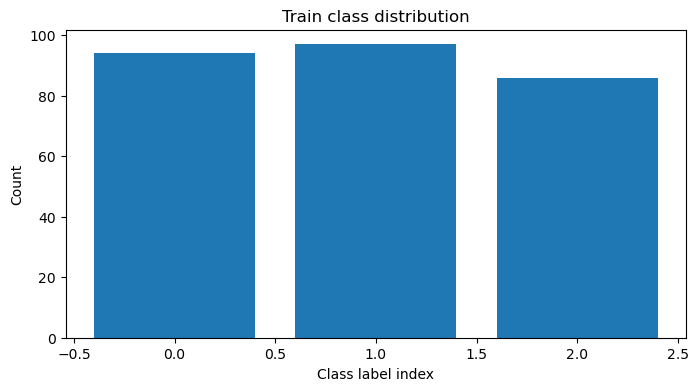

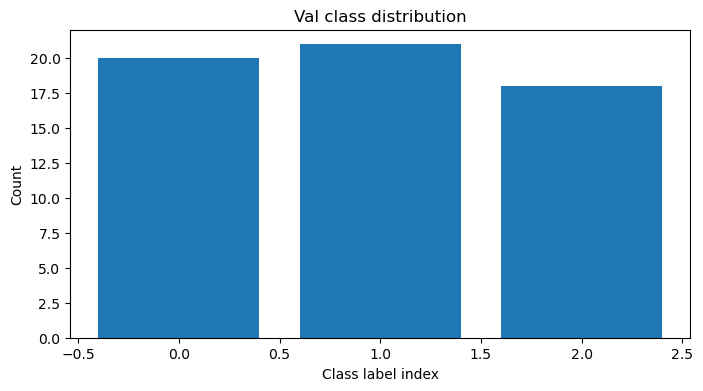

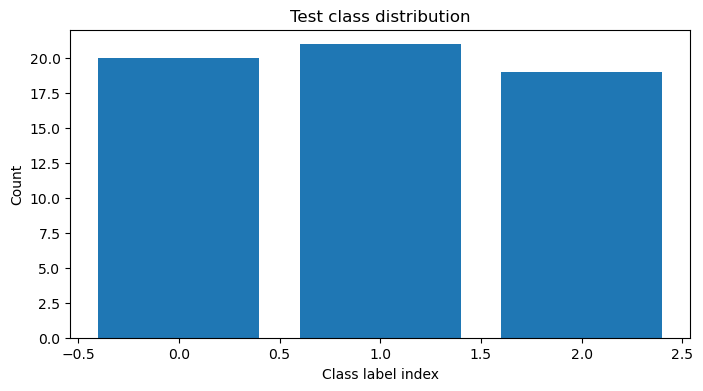

In [4]:
def plot_class_distribution(rows, title):
    labels = [y for _, y in rows]
    counts = defaultdict(int)
    for y in labels:
        counts[y] += 1
    xs = sorted(counts.keys())
    ys = [counts[x] for x in xs]
    plt.figure(figsize=(8,4))
    plt.bar(xs, ys)
    plt.title(title)
    plt.xlabel("Class label index")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(train_rows, "Train class distribution")
plot_class_distribution(val_rows,   "Val class distribution")
plot_class_distribution(test_rows,  "Test class distribution")

### Video Loading & Sampling (OpenCV)

#### Load a video with OpenCV and show frames

In [ ]:
def load_video_cv2(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    ok = True
    while ok:
        ok, frame = cap.read()
        if not ok:
            break
        frames.append(frame)  # BGR
        if max_frames and len(frames) >= max_frames:
            break
    cap.release()
    return frames

def show_frame_grid(frames, n=12, title="Frames", cols=6):
    if len(frames) == 0:
        print("No frames to display")
        return
    n = min(n, len(frames))
    idxs = np.linspace(0, len(frames)-1, n, dtype=int)
    sel = [frames[i] for i in idxs]

    rows = math.ceil(n/cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, fr in enumerate(sel):
        fr_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(fr_rgb)
        plt.axis("off")
        plt.title(f"t={idxs[i]}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


sample_rel, sample_label = train_rows[7] # Pick one sample from train
sample_abs = os.path.join(DATA_ROOT, sample_rel)

frames = load_video_cv2(sample_abs, max_frames=120)
print("Loaded frames:", len(frames), "Label:", sample_label)
show_frame_grid(frames, n=12, title="Raw loaded frames (BGR->RGB shown)")

#### Resize frames to 224×224

Resized frame shape: (224, 224, 3)


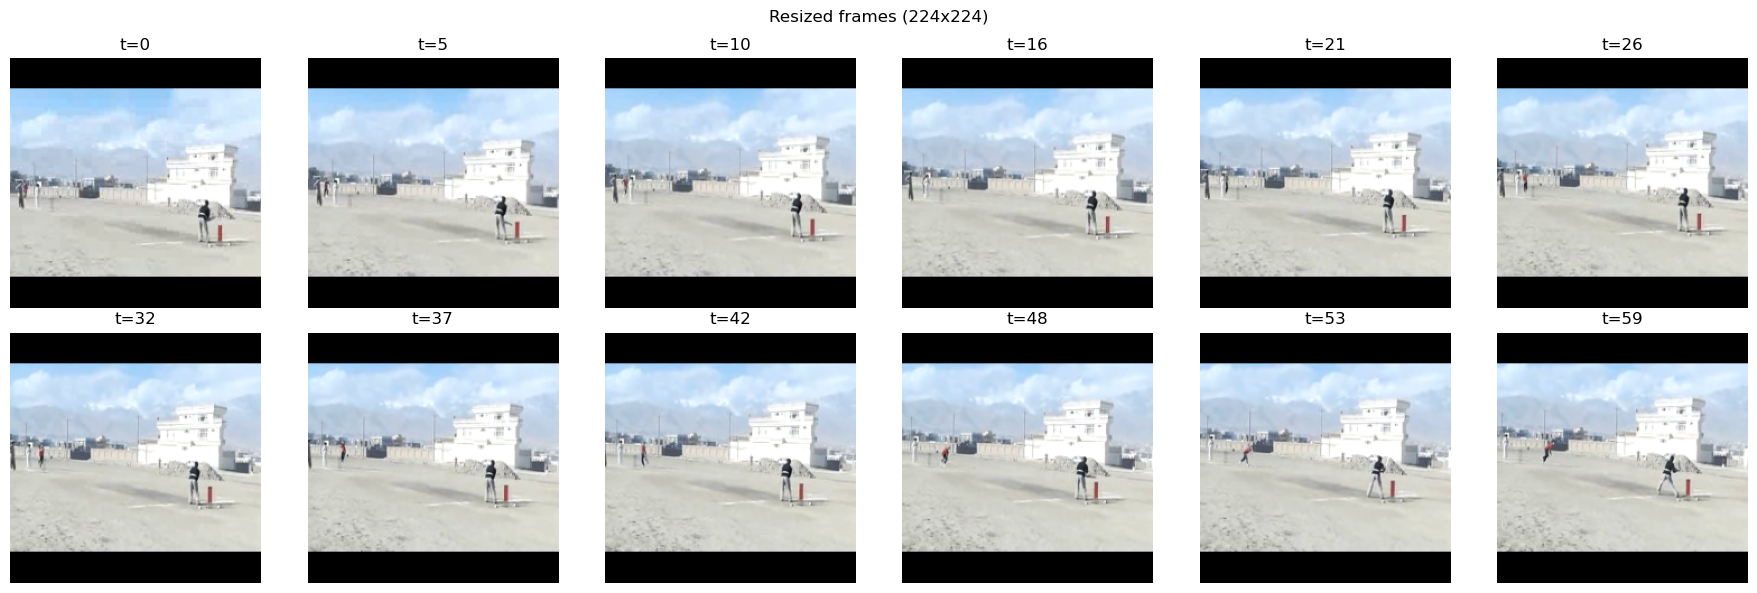

In [6]:
def resize_frames(frames, size=224):
    out = [cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA) for fr in frames]
    return out

resized = resize_frames(frames, IMG_SIZE)
print("Resized frame shape:", resized[0].shape)
show_frame_grid(resized, n=12, title="Resized frames (224x224)")

#### Sampling strategies (Uniform / Dense / Random)

#### Uniform sampling (fixed number of frames)

Uniform sampled: 32


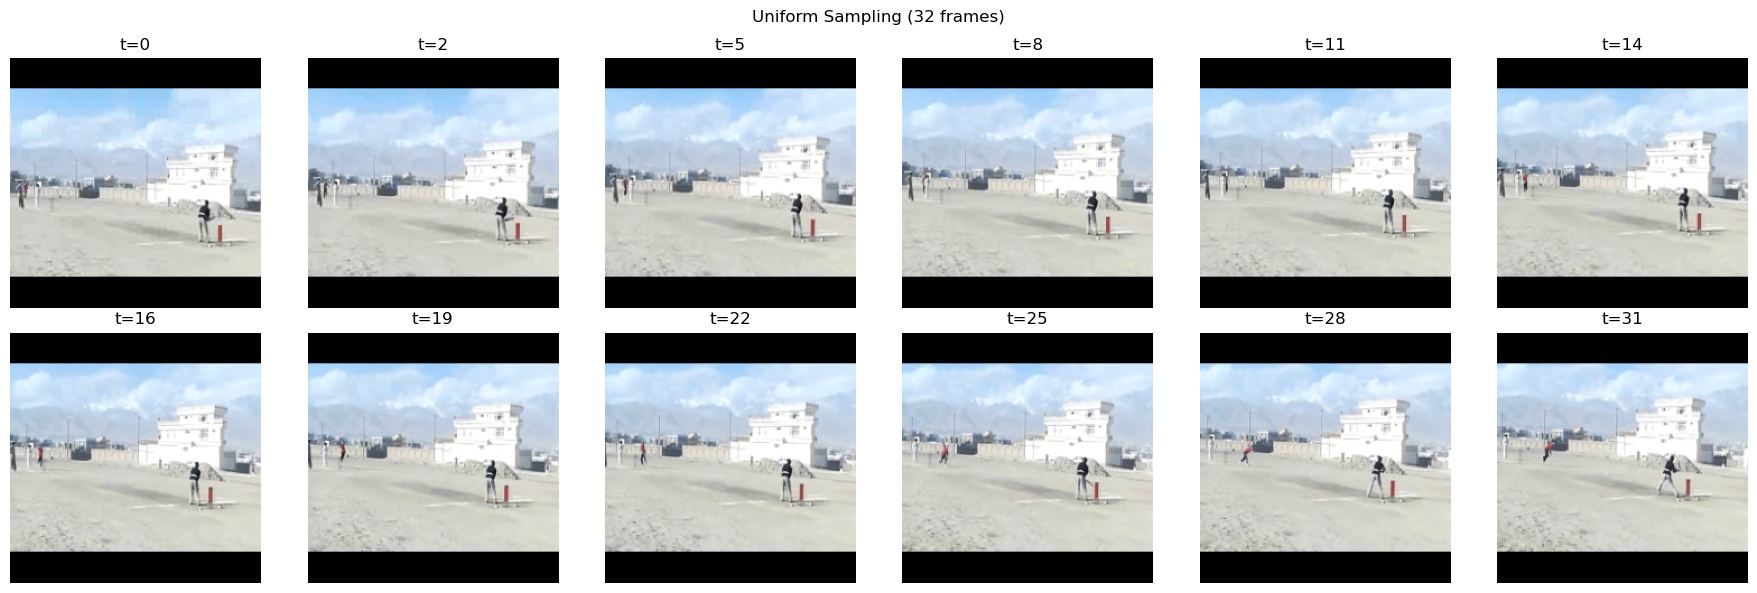

In [7]:
def uniform_sample(frames, num_frames=32):
    if len(frames) == 0:
        return []
    idxs = np.linspace(0, len(frames)-1, num_frames, dtype=int)
    return [frames[i] for i in idxs]

uni = uniform_sample(resized, 32)
print("Uniform sampled:", len(uni))
show_frame_grid(uni, n=12, title="Uniform Sampling (32 frames)")

#### Dense sampling (every frame)

Dense sampled: 60


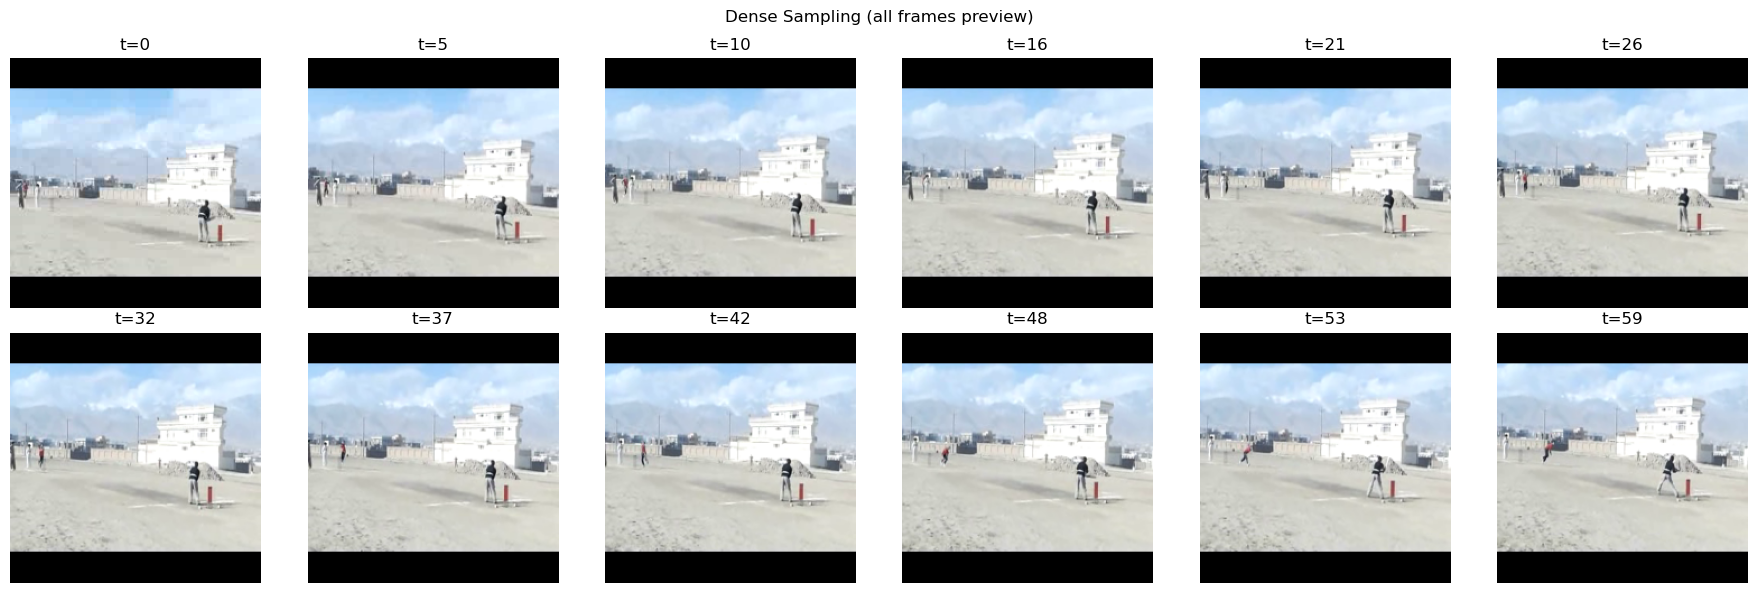

In [8]:
dense = resized  # all frames
print("Dense sampled:", len(dense))
show_frame_grid(dense, n=12, title="Dense Sampling (all frames preview)")

#### Random sampling (augmentation)

Random sampled: 32


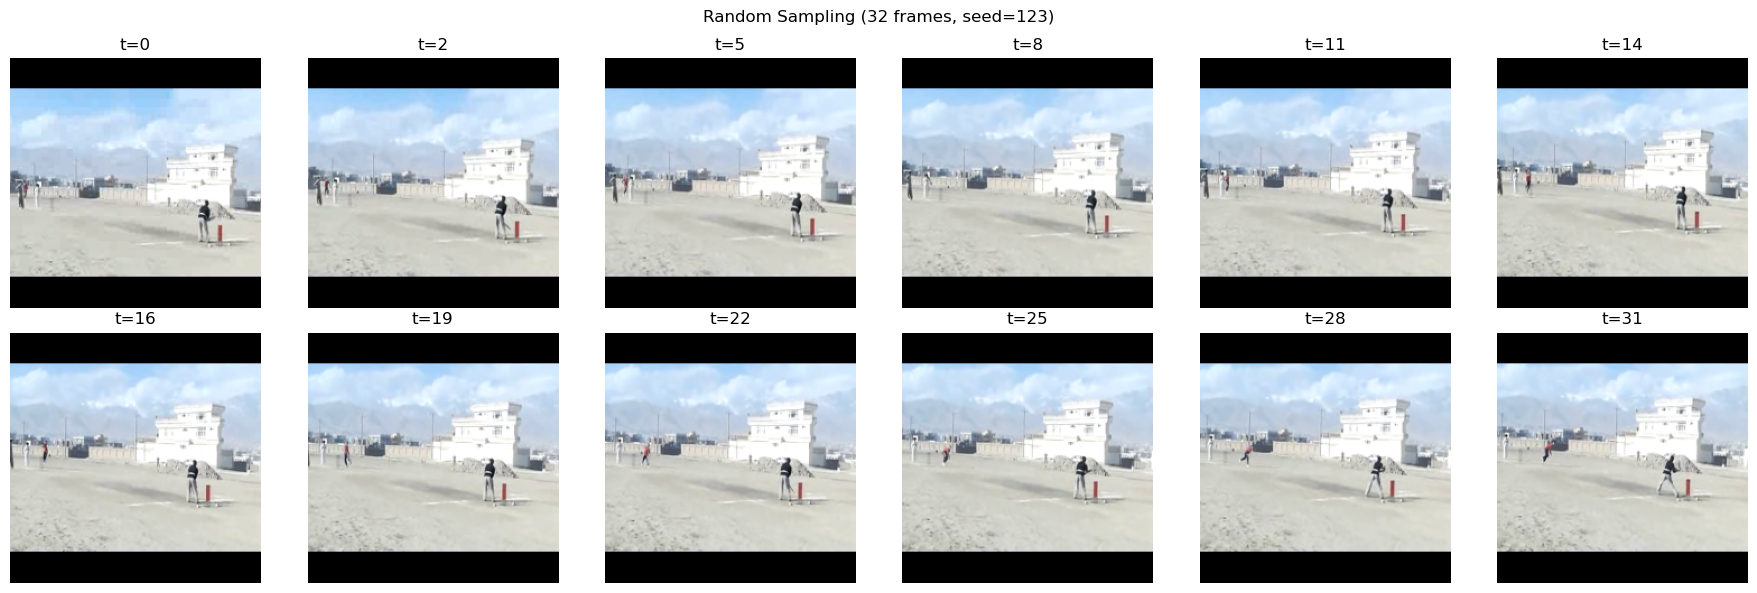

In [9]:
def random_sample(frames, num_frames=32, seed=None):
    if len(frames) == 0:
        return []
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(frames), size=min(num_frames, len(frames)), replace=False)
    idxs = np.sort(idxs)
    return [frames[i] for i in idxs]

rnd = random_sample(resized, 32, seed=123)
print("Random sampled:", len(rnd))
show_frame_grid(rnd, n=12, title="Random Sampling (32 frames, seed=123)")

### Preprocessing & Quality Enhancement (noise/blur/artifacts + normalization + color spaces)

#### Detect blur, noise estimate, and apply enhancements

Frame 0: blur=1013.7 noise=12.49
Frame 1: blur=996.4 noise=12.45
Frame 2: blur=1024.6 noise=12.60
Frame 3: blur=1005.5 noise=12.53
Frame 4: blur=1015.5 noise=12.56
Frame 5: blur=1011.2 noise=12.56


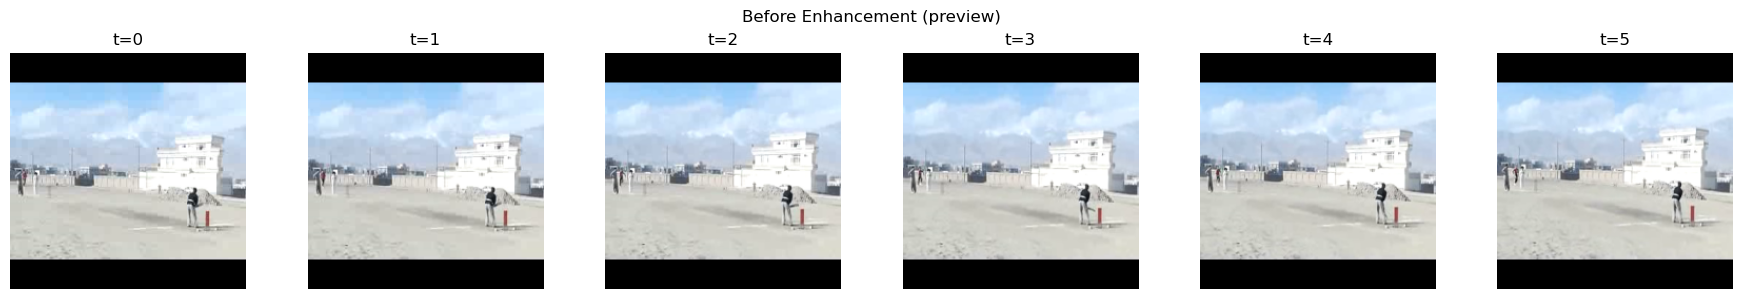

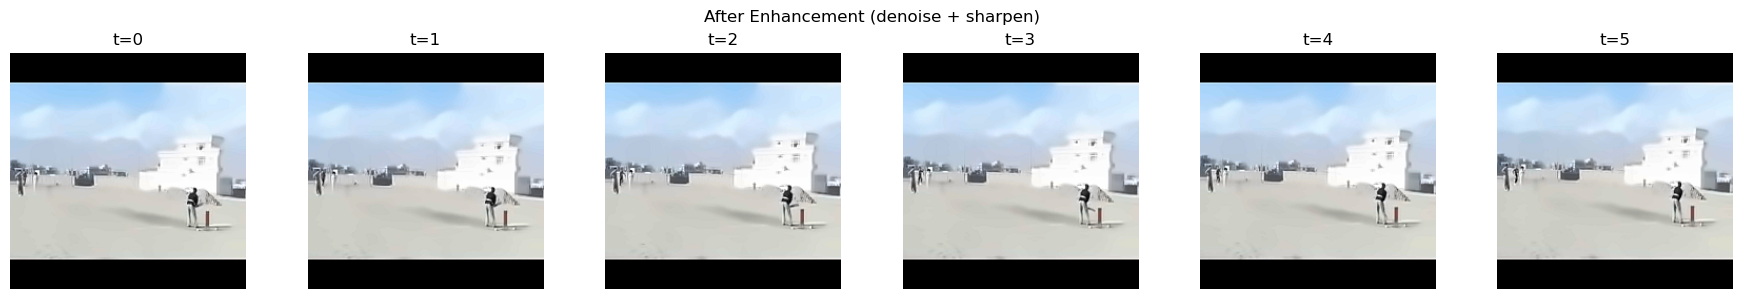

In [10]:
def blur_score(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def noise_estimate(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    resid = gray - blur
    return float(np.std(resid))

def enhance_frame(frame_bgr):
    # Denoise 
    den = cv2.fastNlMeansDenoisingColored(frame_bgr, None, 5, 5, 7, 21)
    # Unsharp mask for mild sharpening
    gauss = cv2.GaussianBlur(den, (0,0), 1.0)
    sharp = cv2.addWeighted(den, 1.5, gauss, -0.5, 0)
    return sharp

# shows before/after for a few frames
test_frames = uni[:6]
enhanced = [enhance_frame(fr) for fr in test_frames]

for i, (a,b) in enumerate(zip(test_frames, enhanced)):
    print(f"Frame {i}: blur={blur_score(a):.1f} noise={noise_estimate(a):.2f}")

show_frame_grid(test_frames, n=6, cols=6, title="Before Enhancement (preview)")
show_frame_grid(enhanced,   n=6, cols=6, title="After Enhancement (denoise + sharpen)")

#### Frame normalization (pixel scaling)

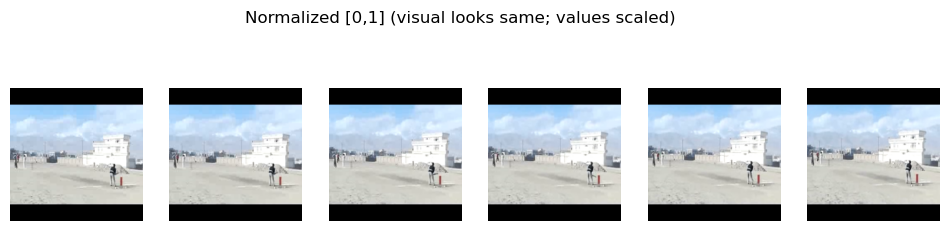

Pixel range example: 0.0 1.0


In [11]:
def normalize_01(frame_bgr):
    return frame_bgr.astype(np.float32) / 255.0

normed = [normalize_01(fr) for fr in test_frames]

# visualize as images
plt.figure(figsize=(12,3))
for i, fr in enumerate(normed):
    fr_rgb = cv2.cvtColor((fr*255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.subplot(1,6,i+1)
    plt.imshow(fr_rgb)
    plt.axis("off")
plt.suptitle("Normalized [0,1] (visual looks same; values scaled)")
plt.show()

print("Pixel range example:", normed[0].min(), normed[0].max())

#### Color space conversions (RGB/HSV/Gray)

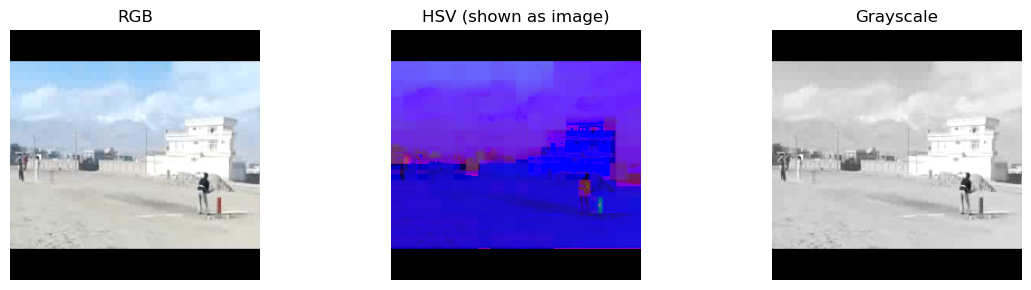

In [12]:
def convert_spaces(frame_bgr):
    rgb  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    hsv  = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    return rgb, hsv, gray

fr = test_frames[0]
rgb, hsv, gray = convert_spaces(fr)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.imshow(rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(hsv); plt.title("HSV (shown as image)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")
plt.tight_layout(); plt.show()

### Feature Normalization (ImageNet stats OR dataset stats) + invalid values handling

#### ImageNet normalization (standard for EfficientNet)

In [13]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

imgnet_norm = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
print("Using ImageNet normalization:", IMAGENET_MEAN, IMAGENET_STD)

Using ImageNet normalization: (0.485, 0.456, 0.406) (0.229, 0.224, 0.225)


1.4.2 Compute dataset mean/std (optional) — visual + print

In [14]:
def compute_dataset_stats(rows, sample_videos=50, frames_per_video=8):
    means, sqmeans = [], []
    pick = rows[:min(sample_videos, len(rows))]
    for rel, _ in tqdm(pick, desc="Computing stats"):
        abs_path = os.path.join(DATA_ROOT, rel)
        frames = load_video_cv2(abs_path, max_frames=200)
        frames = resize_frames(frames, IMG_SIZE)
        samp = uniform_sample(frames, frames_per_video)
        for fr in samp:
            fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
            means.append(fr.mean(axis=(0,1)))
            sqmeans.append((fr**2).mean(axis=(0,1)))
    mean = np.mean(means, axis=0)
    var  = np.mean(sqmeans, axis=0) - mean**2
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean, std

# Uncomment to run:
ds_mean, ds_std = compute_dataset_stats(train_rows, sample_videos=40, frames_per_video=4)
print("Dataset mean:", ds_mean, "Dataset std:", ds_std)

Computing stats: 100%|██████████| 40/40 [00:03<00:00, 12.07it/s]

Dataset mean: [0.43803462 0.43827152 0.3617085 ] Dataset std: [0.26079163 0.25278485 0.25376225]


1.4.3 Handle missing/invalid feature values (NaN/Inf) — visual demo

In [15]:
def sanitize_tensor(x: torch.Tensor):
    # replaces NaN/Inf with finite values
    x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
    return x

demo = torch.tensor([0.0, float('nan'), float('inf'), -float('inf')])
print("Before:", demo)
print("After :", sanitize_tensor(demo))

Before: tensor([0., nan, inf, -inf])
After : tensor([ 0.,  0.,  1., -1.])


### Develop (Model Training)

#### Dataset Loader (common to all models) — uses split files

* FrameDataset2D: returns (T, C, H, W) for EfficientNet pooling
* ClipDataset3D: returns (C, T, H, W) for 3D CNN models

In [16]:
class FrameDataset2D(Dataset):
    def __init__(self, rows, num_frames=32, sampling="uniform", enhance=True, use_imagenet_norm=True):
        self.rows = rows
        self.num_frames = num_frames
        self.sampling = sampling
        self.enhance = enhance

        self.to_tensor = transforms.ToTensor()  # HWC[0..255] -> CHW[0..1]
        self.norm = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) if use_imagenet_norm else None

    def _sample(self, frames):
        if self.sampling == "uniform":
            return uniform_sample(frames, self.num_frames)
        elif self.sampling == "dense":
            return frames
        elif self.sampling == "random":
            return random_sample(frames, self.num_frames)
        else:
            raise ValueError("Unknown sampling")

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        rel, label = self.rows[idx]
        abs_path = os.path.join(DATA_ROOT, rel)

        frames = load_video_cv2(abs_path, max_frames=400)
        frames = resize_frames(frames, IMG_SIZE)

        frames = self._sample(frames)
        if self.enhance:
            frames = [enhance_frame(fr) for fr in frames]

        # Convert to tensor list: (C,H,W)
        tensor_frames = []
        for fr in frames:
            fr_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            t = self.to_tensor(fr_rgb)
            if self.norm:
                t = self.norm(t)
            tensor_frames.append(t)

        x = torch.stack(tensor_frames, dim=0)  # (T,C,H,W)
        x = sanitize_tensor(x)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


class ClipDataset3D(Dataset):
    def __init__(self, rows, clip_len=16, sampling="uniform", enhance=True, use_imagenet_norm=True):
        self.rows = rows
        self.clip_len = clip_len
        self.sampling = sampling
        self.enhance = enhance

        self.to_tensor = transforms.ToTensor()
        self.norm = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) if use_imagenet_norm else None

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        rel, label = self.rows[idx]
        abs_path = os.path.join(DATA_ROOT, rel)

        frames = load_video_cv2(abs_path, max_frames=400)
        frames = resize_frames(frames, IMG_SIZE)

        # choose exactly clip_len frames
        if self.sampling == "uniform":
            frames = uniform_sample(frames, self.clip_len)
        elif self.sampling == "random":
            frames = random_sample(frames, self.clip_len)
        else:
            frames = uniform_sample(frames, self.clip_len)

        if self.enhance:
            frames = [enhance_frame(fr) for fr in frames]

        # Build (C,T,H,W)
        clip = []
        for fr in frames:
            fr_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            t = self.to_tensor(fr_rgb)
            if self.norm:
                t = self.norm(t)
            clip.append(t)
        clip = torch.stack(clip, dim=1)  # (C,T,H,W)
        clip = sanitize_tensor(clip)

        y = torch.tensor(label, dtype=torch.long)
        return clip, y

#### Dataloaders for 2D CNN

In [17]:
BATCH_2D = 2
BATCH_3D = 2

train_ds_2d = FrameDataset2D(train_rows, num_frames=32, sampling="uniform")
val_ds_2d   = FrameDataset2D(val_rows,   num_frames=32, sampling="uniform")
test_ds_2d  = FrameDataset2D(test_rows,  num_frames=32, sampling="uniform")

train_dl_2d = DataLoader(train_ds_2d, batch_size=BATCH_2D, shuffle=True, num_workers=0)
val_dl_2d   = DataLoader(val_ds_2d,   batch_size=BATCH_2D, shuffle=False, num_workers=0)

x, y = next(iter(train_dl_2d))
print("2D batch x:", x.shape, "y:", y.shape)  # (B,T,C,H,W)

2D batch x: torch.Size([2, 32, 3, 224, 224]) y: torch.Size([2])


### Implement 2D CNN + Temporal Pooling (EfficientNet-B0)

#### EfficientNet-B0 feature extractor (pretrained)

In [18]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
eff = torchvision.models.efficientnet_b0(weights=weights)

# Replace classifier with identity; we want features
eff.classifier = nn.Identity()

eff = eff.to(DEVICE)
eff.eval()

# Feature dim check
dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
with torch.no_grad():
    feat = eff(dummy)
print("EfficientNet-B0 feature dim:", feat.shape)  # (1, 1280)

EfficientNet-B0 feature dim: torch.Size([1, 1280])


#### Temporal pooling modules (Avg / Max / Attention)

#### Attention-based pooling (learn weights over time)

In [19]:
class TemporalAttentionPool(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.fc1 = nn.Linear(feat_dim, feat_dim // 2)
        self.fc2 = nn.Linear(feat_dim // 2, 1)

    def forward(self, feats):  # feats: (B,T,D)
        h = torch.tanh(self.fc1(feats))
        scores = self.fc2(h).squeeze(-1)     # (B,T)
        attn = torch.softmax(scores, dim=1)  # (B,T)
        pooled = torch.sum(feats * attn.unsqueeze(-1), dim=1)  # (B,D)
        return pooled, attn

#### Full model: EfficientNet + Temporal Pooling + classifier head

In [20]:
class EfficientNetTemporal(nn.Module):
    def __init__(self, num_classes, pooling="avg", dropout=0.3, fine_tune_last_n=2):
        super().__init__()
        weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
        self.backbone = torchvision.models.efficientnet_b0(weights=weights)
        self.backbone.classifier = nn.Identity()
        self.feat_dim = 1280

        self.pooling = pooling
        if pooling == "attn":
            self.attn_pool = TemporalAttentionPool(self.feat_dim)

        self.ln = nn.LayerNorm(self.feat_dim)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(self.feat_dim, num_classes)

        # freeze everything, unfreeze last N blocks
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Unfreeze last few layers (rough strategy)
        # EfficientNet features are in backbone.features (a Sequential)
        for block in list(self.backbone.features.children())[-fine_tune_last_n:]:
            for p in block.parameters():
                p.requires_grad = True

    def forward(self, x):  # x: (B,T,C,H,W)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feats = self.backbone(x)          # (B*T, D)
        feats = feats.view(B, T, -1)      # (B, T, D)

        if self.pooling == "avg":
            pooled = feats.mean(dim=1)
            attn = None
        elif self.pooling == "max":
            pooled = feats.max(dim=1).values
            attn = None
        elif self.pooling == "attn":
            pooled, attn = self.attn_pool(feats)
        else:
            raise ValueError("pooling must be avg/max/attn")

        pooled = self.ln(pooled)
        pooled = self.drop(pooled)
        logits = self.fc(pooled)
        return logits, attn

#### Visual output: sample attention weights for one video

Attention shape: torch.Size([2, 32])


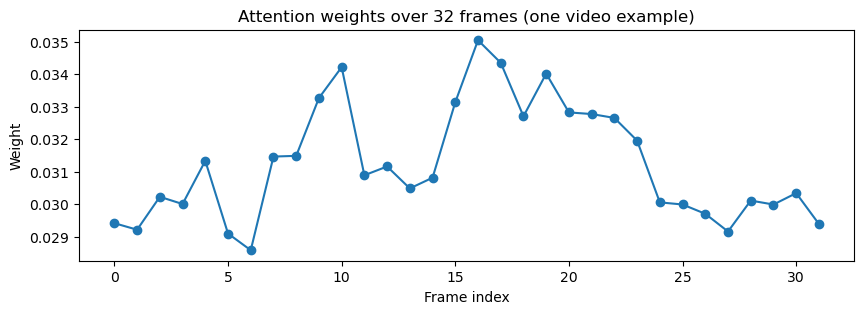

In [22]:
model_attn = EfficientNetTemporal(NUM_CLASSES, pooling="attn").to(DEVICE)
model_attn.eval()

x, y = next(iter(val_dl_2d))
x = x.to(DEVICE)

with torch.no_grad():
    logits, attn = model_attn(x)

print("Attention shape:", attn.shape)  # (B,T)
plt.figure(figsize=(10,3))
plt.plot(attn[0].cpu().numpy(), marker="o")
plt.title("Attention weights over 32 frames (one video example)")
plt.xlabel("Frame index")
plt.ylabel("Weight")
plt.show()

#### Training utilities (Adam, StepLR, Early Stopping, L2, Dropout, LayerNorm)

#### Early stopping + training loop (shared)

In [23]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, val_metric):
        if self.best is None or val_metric > self.best + self.min_delta:
            self.best = val_metric
            self.count = 0
            return False
        self.count += 1
        return self.count >= self.patience


def run_epoch_2d(model, loader, optimizer=None, weight_decay=1e-4):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, ys, ps = 0.0, [], []
    start = time.perf_counter()

    for x, y in tqdm(loader, desc="Train" if is_train else "Eval", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        logits, _ = model(x)
        loss = F.cross_entropy(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        ys.extend(y.detach().cpu().tolist())
        ps.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())

    dur = time.perf_counter() - start
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(ys, ps)
    return avg_loss, acc, dur

#### Train three pooling variants (Avg, Max, Attention)

[avg] Epoch 01: train loss 0.7983 acc 0.639 | val loss 0.4842 acc 0.881


[avg] Epoch 02: train loss 0.5308 acc 0.816 | val loss 0.3864 acc 0.949


[avg] Epoch 03: train loss 0.4199 acc 0.841 | val loss 0.2753 acc 0.966


[avg] Epoch 04: train loss 0.3685 acc 0.856 | val loss 0.2782 acc 0.966


[avg] Epoch 05: train loss 0.2601 acc 0.910 | val loss 0.2671 acc 0.949


[avg] Epoch 06: train loss 0.2389 acc 0.921 | val loss 0.2757 acc 0.898


[avg] Epoch 07: train loss 0.2057 acc 0.953 | val loss 0.2721 acc 0.915
Early stopping triggered.


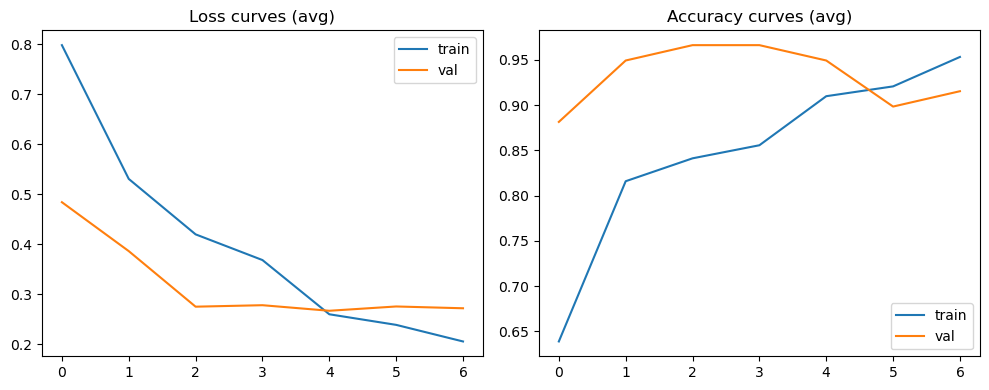

Best saved: best_2d_avg.pt best val acc: 0.9661016949152542


[max] Epoch 01: train loss 0.9037 acc 0.549 | val loss 0.5440 acc 0.797


[max] Epoch 02: train loss 0.6978 acc 0.704 | val loss 0.4532 acc 0.864


[max] Epoch 03: train loss 0.5690 acc 0.744 | val loss 0.3650 acc 0.932


[max] Epoch 04: train loss 0.4269 acc 0.859 | val loss 0.3213 acc 0.932


[max] Epoch 05: train loss 0.3587 acc 0.848 | val loss 0.3005 acc 0.949


[max] Epoch 06: train loss 0.3395 acc 0.888 | val loss 0.2613 acc 0.949


[max] Epoch 07: train loss 0.3259 acc 0.888 | val loss 0.2943 acc 0.932


[max] Epoch 08: train loss 0.2826 acc 0.913 | val loss 0.2323 acc 0.966


[max] Epoch 09: train loss 0.2661 acc 0.924 | val loss 0.2351 acc 0.949


[max] Epoch 10: train loss 0.2603 acc 0.924 | val loss 0.2289 acc 0.983


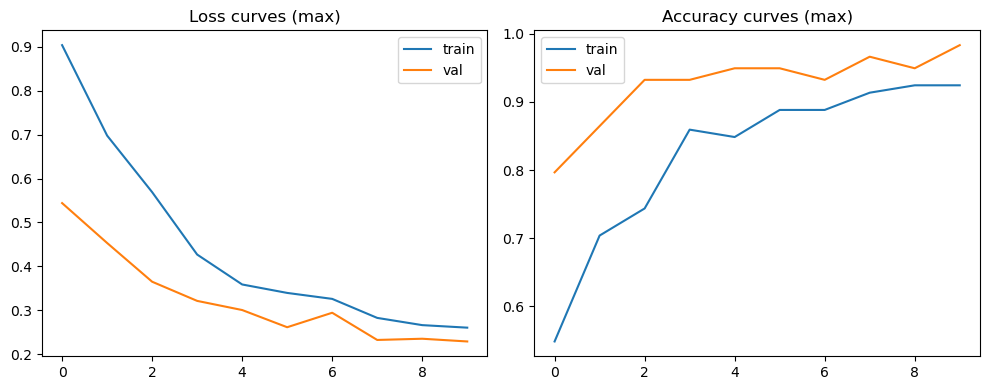

Best saved: best_2d_max.pt best val acc: 0.9830508474576272


[attn] Epoch 01: train loss 0.7728 acc 0.679 | val loss 0.4735 acc 0.881


[attn] Epoch 02: train loss 0.4828 acc 0.827 | val loss 0.3459 acc 0.915


[attn] Epoch 03: train loss 0.4007 acc 0.848 | val loss 0.2920 acc 0.932


[attn] Epoch 04: train loss 0.2920 acc 0.906 | val loss 0.3335 acc 0.915


[attn] Epoch 05: train loss 0.2809 acc 0.931 | val loss 0.2481 acc 0.932


[attn] Epoch 06: train loss 0.1701 acc 0.953 | val loss 0.2384 acc 0.932


[attn] Epoch 07: train loss 0.1689 acc 0.953 | val loss 0.2153 acc 0.949


[attn] Epoch 08: train loss 0.1417 acc 0.975 | val loss 0.2153 acc 0.949


[attn] Epoch 09: train loss 0.1482 acc 0.964 | val loss 0.2128 acc 0.949


[attn] Epoch 10: train loss 0.1473 acc 0.949 | val loss 0.2768 acc 0.915


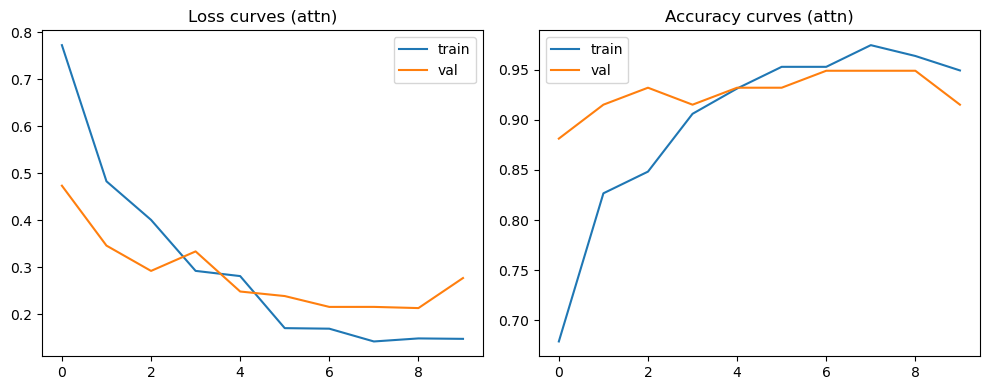

Best saved: best_2d_attn.pt best val acc: 0.9491525423728814


In [24]:
def train_model_2d(pooling="avg", epochs=10, lr=1e-4, step=5, gamma=0.5, patience=4):
    model = EfficientNetTemporal(NUM_CLASSES, pooling=pooling, dropout=0.3, fine_tune_last_n=2).to(DEVICE)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
    stopper = EarlyStopper(patience=patience)

    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": [], "train_time": [], "val_time": []}
    best_path = f"best_2d_{pooling}.pt"
    best_val = -1

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_t = run_epoch_2d(model, train_dl_2d, optimizer=optimizer)
        va_loss, va_acc, va_t = run_epoch_2d(model, val_dl_2d, optimizer=None)

        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["train_time"].append(tr_t)
        history["val_time"].append(va_t)

        print(f"[{pooling}] Epoch {ep:02d}: "
              f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.3f}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)

        if stopper.step(va_acc):
            print("Early stopping triggered.")
            break

    # plot curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title(f"Loss curves ({pooling})"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="train")
    plt.plot(history["val_acc"], label="val")
    plt.title(f"Accuracy curves ({pooling})"); plt.legend()
    plt.tight_layout(); plt.show()

    print("Best saved:", best_path, "best val acc:", best_val)
    return best_path, history

# Train variants 
best_avg, hist_avg = train_model_2d("avg", epochs=10)
best_max, hist_max = train_model_2d("max", epochs=10)
best_att, hist_att = train_model_2d("attn", epochs=10)

### Implement C3D / I3D-style 3D CNN (pretrained 3D model, 16-frame clip)

#### Dataloader for 3D clips

In [25]:
train_ds_3d = ClipDataset3D(train_rows, clip_len=16, sampling="uniform")
val_ds_3d   = ClipDataset3D(val_rows,   clip_len=16, sampling="uniform")
test_ds_3d  = ClipDataset3D(test_rows,  clip_len=16, sampling="uniform")

train_dl_3d = DataLoader(train_ds_3d, batch_size=BATCH_3D, shuffle=True, num_workers=0)
val_dl_3d   = DataLoader(val_ds_3d,   batch_size=BATCH_3D, shuffle=False, num_workers=0)

x3, y3 = next(iter(train_dl_3d))
print("3D batch clip:", x3.shape, "labels:", y3.shape)  # (B,C,T,H,W)

3D batch clip: torch.Size([2, 3, 16, 224, 224]) labels: torch.Size([2])


#### Pretrained 3D CNN model + fine-tuning

In [26]:
def build_3d_model(num_classes):
    # r3d_18 (3D ResNet-18)
    weights = torchvision.models.video.R3D_18_Weights.DEFAULT
    model = torchvision.models.video.r3d_18(weights=weights)

    # Replacing classifier
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(
        nn.LayerNorm(in_feats),
        nn.Dropout(0.3),
        nn.Linear(in_feats, num_classes)
    )

    # Fine-tune last layers: freeze most, unfreeze layer4 + fc
    for p in model.parameters():
        p.requires_grad = False

    for p in model.layer4.parameters():
        p.requires_grad = True
    for p in model.fc.parameters():
        p.requires_grad = True

    return model

model3d = build_3d_model(NUM_CLASSES).to(DEVICE)
print("3D model ready.")

3D model ready.


#### Training loop (Adam, StepLR, Early stopping, L2, Dropout, LayerNorm)

[3D] Epoch 01: train loss 0.8917 acc 0.650 | val loss 0.2184 acc 0.898


[3D] Epoch 02: train loss 0.5633 acc 0.798 | val loss 0.1946 acc 0.949


[3D] Epoch 03: train loss 0.4365 acc 0.845 | val loss 0.1514 acc 0.983


[3D] Epoch 04: train loss 0.2962 acc 0.881 | val loss 0.1522 acc 0.966


[3D] Epoch 05: train loss 0.2649 acc 0.913 | val loss 0.1412 acc 0.949


[3D] Epoch 06: train loss 0.1820 acc 0.931 | val loss 0.2473 acc 0.864


[3D] Epoch 07: train loss 0.1236 acc 0.946 | val loss 0.0601 acc 1.000


[3D] Epoch 08: train loss 0.1020 acc 0.978 | val loss 0.0908 acc 0.983


[3D] Epoch 09: train loss 0.0724 acc 0.982 | val loss 0.0553 acc 0.983


[3D] Epoch 10: train loss 0.0665 acc 0.978 | val loss 0.0646 acc 1.000


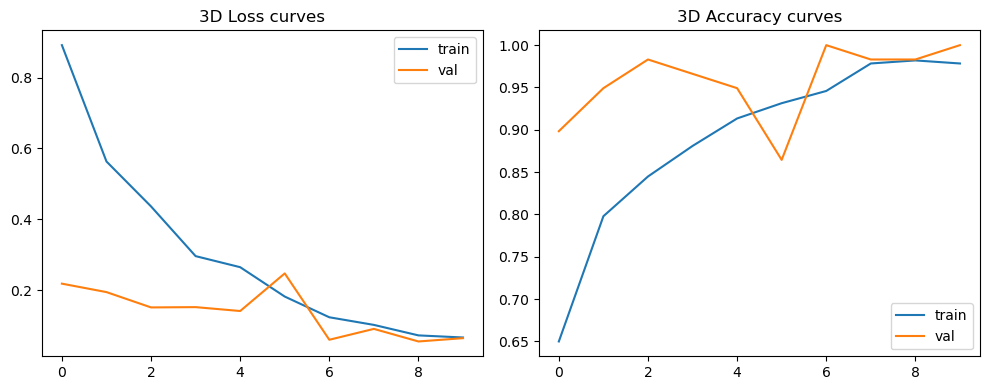

Best saved: best_3d_r3d18.pt best val acc: 1.0


In [ ]:
def run_epoch_3d(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, ys, ps = 0.0, [], []
    start = time.perf_counter()

    for x, y in tqdm(loader, desc="Train3D" if is_train else "Eval3D", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        ys.extend(y.detach().cpu().tolist())
        ps.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())

    dur = time.perf_counter() - start
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(ys, ps)
    return avg_loss, acc, dur


def train_model_3d(epochs=10, lr=1e-4, step=5, gamma=0.5, patience=4):
    model = build_3d_model(NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)
    stopper = EarlyStopper(patience=patience)

    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": [], "train_time": [], "val_time": []}
    best_path = f"best_3d_r3d18.pt"
    best_val = -1

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_t = run_epoch_3d(model, train_dl_3d, optimizer=optimizer)
        va_loss, va_acc, va_t = run_epoch_3d(model, val_dl_3d, optimizer=None)
        scheduler.step()

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["train_time"].append(tr_t)
        history["val_time"].append(va_t)

        print(f"[3D] Epoch {ep:02d}: train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)

        if stopper.step(va_acc):
            print("Early stopping triggered.")
            break

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title("3D Loss curves"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="train")
    plt.plot(history["val_acc"], label="val")
    plt.title("3D Accuracy curves"); plt.legend()
    plt.tight_layout(); plt.show()

    print("Best saved:", best_path, "best val acc:", best_val)
    return best_path, history

best_3d, hist_3d = train_model_3d(epochs=10)

### Evaluation Metrics for ALL Approaches (Accuracy/Precision/Recall/F1/CM/ROC/AUC + timings + memory + params)

#### 1) Compare performance metrics across models
#### 2) Plot metrics + confusion matrix + ROC/AUC (multi-class)
#### 3) Model size, memory usage, training/inference time
#### 4) Trade-offs (accuracy vs cost)

In [54]:
@torch.no_grad()
def eval_deep_2d(model, rows, batch=2):
    ds = FrameDataset2D(rows, num_frames=32, sampling="uniform")
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=0)

    model.eval()
    ys, preds, probs = [], [], []
    start = time.perf_counter()
    for x, y in tqdm(dl, desc="Eval2D"):
        x = x.to(DEVICE)
        logits, _ = model(x)
        p = torch.softmax(logits, dim=1)
        probs.append(p.cpu().numpy())
        preds.extend(torch.argmax(p, dim=1).cpu().tolist())
        ys.extend(y.tolist())
    total = time.perf_counter() - start
    probs = np.concatenate(probs, axis=0)
    infer_per_video = total / len(rows)
    return np.array(ys), np.array(preds), probs, infer_per_video


@torch.no_grad()
def eval_deep_3d(model, rows, batch=2):
    ds = ClipDataset3D(rows, clip_len=16, sampling="uniform")
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=0)

    model.eval()
    ys, preds, probs = [], [], []
    start = time.perf_counter()
    for x, y in tqdm(dl, desc="Eval3D"):
        x = x.to(DEVICE)
        logits = model(x)
        p = torch.softmax(logits, dim=1)
        probs.append(p.cpu().numpy())
        preds.extend(torch.argmax(p, dim=1).cpu().tolist())
        ys.extend(y.tolist())
    total = time.perf_counter() - start
    probs = np.concatenate(probs, axis=0)
    infer_per_video = total / len(rows)
    return np.array(ys), np.array(preds), probs, infer_per_video

def compare_models_bar(results, metric="accuracy", title="Comparison"):
    names = list(results.keys())
    vals = [results[n][metric] for n in names]
    plt.figure(figsize=(8,4))
    plt.bar(names, vals)
    plt.title(title)
    plt.ylabel(metric)
    plt.xticks(rotation=20)
    plt.show()


=== Evaluating 2D EfficientNet Models ===

--- 2D EfficientNet (Average Pooling) ---


Eval2D: 100%|██████████| 30/30 [02:20<00:00,  4.68s/it]


=== 2D-Avg Pool ===
Accuracy: 0.9333333333333333
Macro Precision: 0.9380032206119163
Macro Recall: 0.934126984126984
Macro F1: 0.934609250398724

Per-class report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.87      0.95      0.91        21
           2       1.00      1.00      1.00        19

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



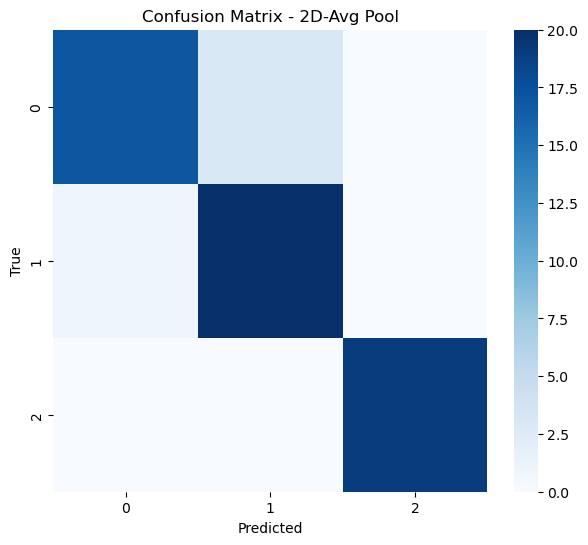

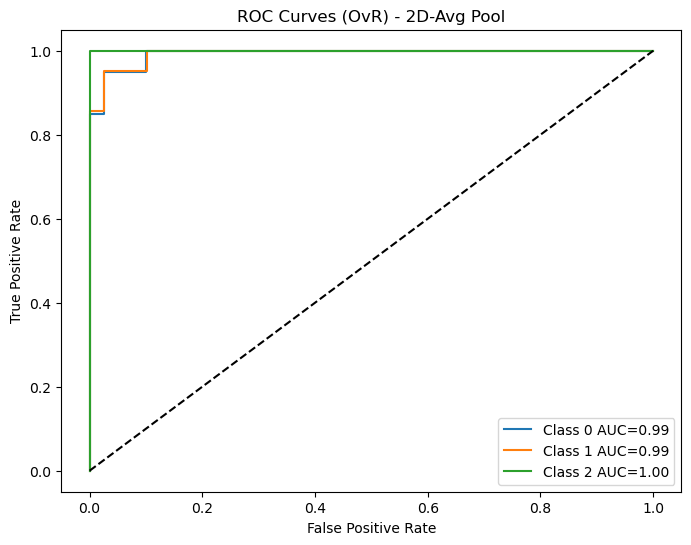

Macro AUC (OvR): 0.9950579975579976
2D-Avg: params=4,013,951 (~15.31 MB fp32)

--- 2D EfficientNet (Max Pooling) ---


Eval2D: 100%|██████████| 30/30 [02:18<00:00,  4.61s/it]


=== 2D-Max Pool ===
Accuracy: 0.9666666666666667
Macro Precision: 0.9674603174603175
Macro Recall: 0.9674603174603175
Macro F1: 0.967032967032967

Per-class report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      0.95      0.95        21
           2       0.95      1.00      0.97        19

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



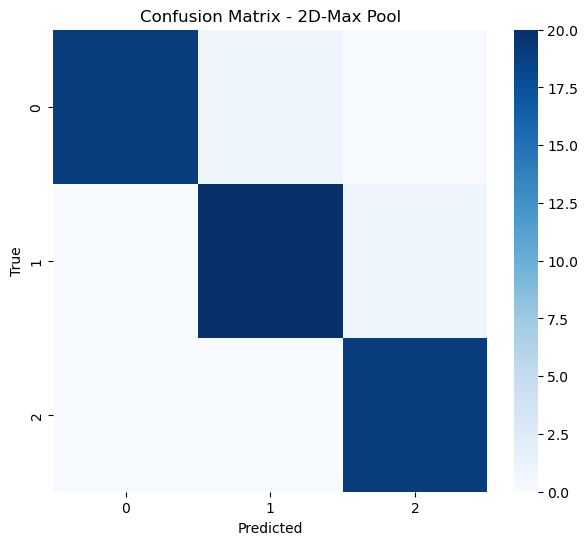

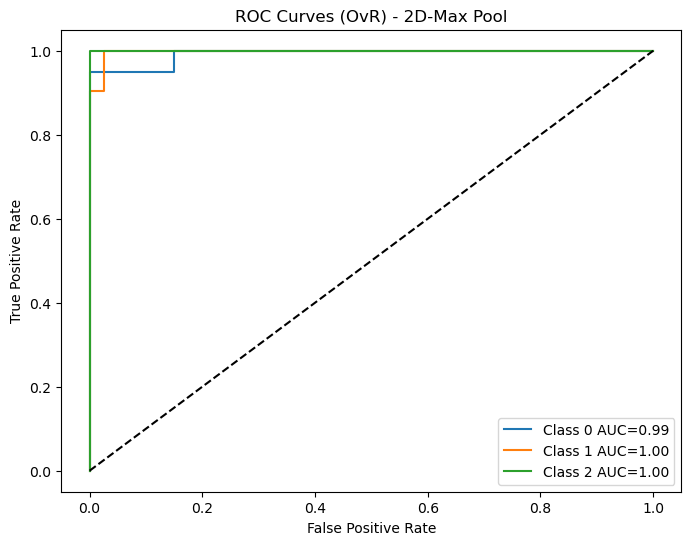

Macro AUC (OvR): 0.9966859991859991
2D-Max: params=4,013,951 (~15.31 MB fp32)

--- 2D EfficientNet (Attention Pooling) ---


Eval2D: 100%|██████████| 30/30 [02:18<00:00,  4.62s/it]


=== 2D-Attn Pool ===
Accuracy: 0.9
Macro Precision: 0.9076479076479077
Macro Recall: 0.9022974101921469
Macro F1: 0.8998716302952503

Per-class report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      0.81      0.89        21
           2       0.82      0.95      0.88        19

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



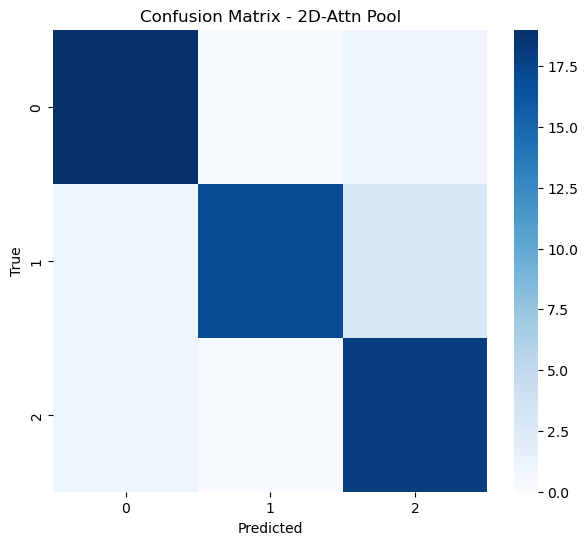

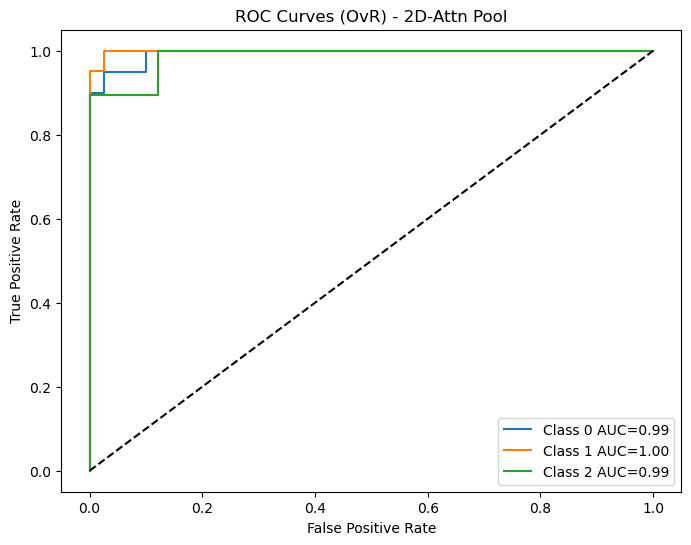

Macro AUC (OvR): 0.9932306761013435
2D-Attn: params=4,834,432 (~18.44 MB fp32)

=== Evaluating 3D R3D-18 Model ===


Eval3D: 100%|██████████| 30/30 [01:10<00:00,  2.36s/it]


=== 3D R3D-18 ===
Accuracy: 1.0
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1: 1.0

Per-class report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        19

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



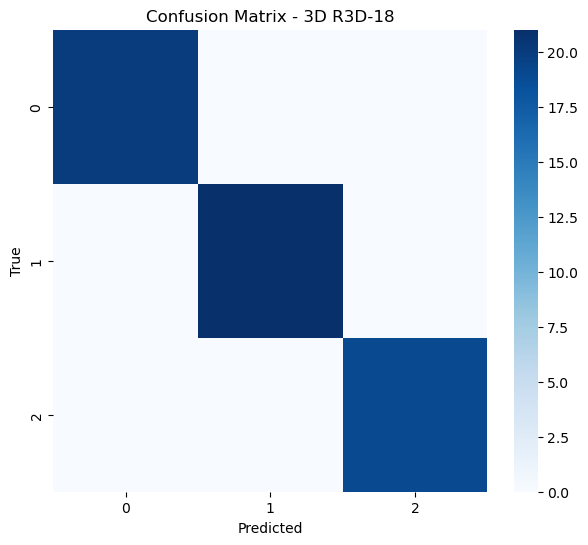

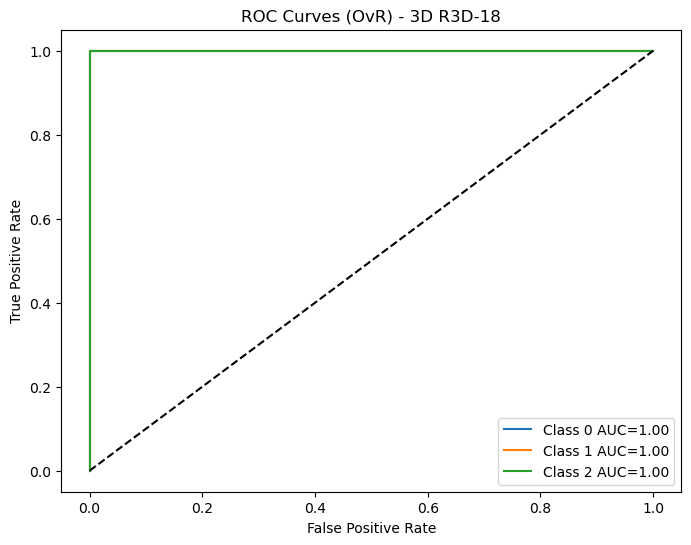

Macro AUC (OvR): 1.0
3D-R3D18: params=33,168,835 (~126.53 MB fp32)

=== Overall Model Comparison ===


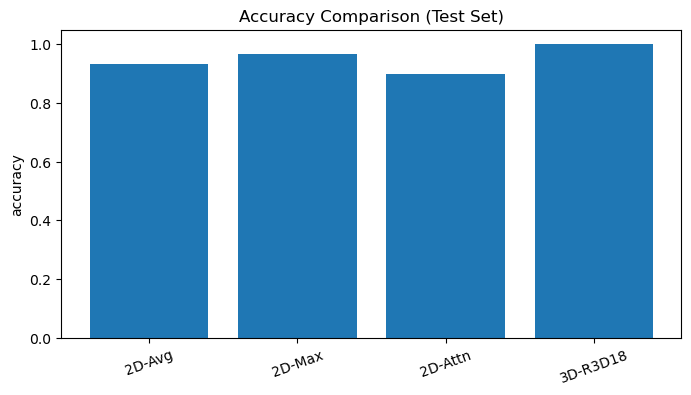

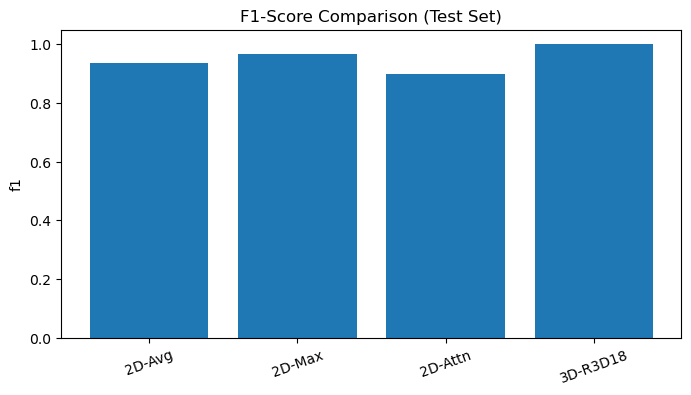

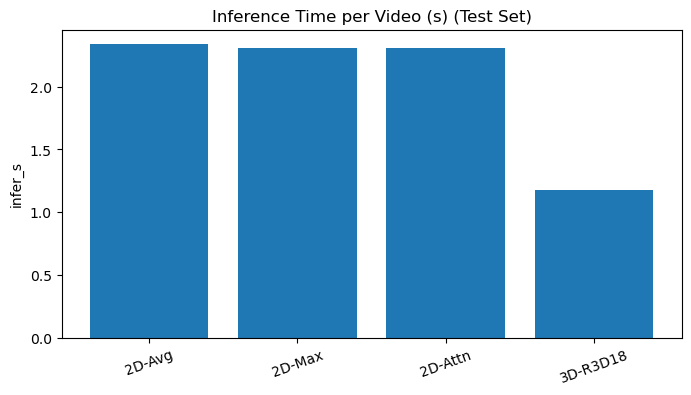

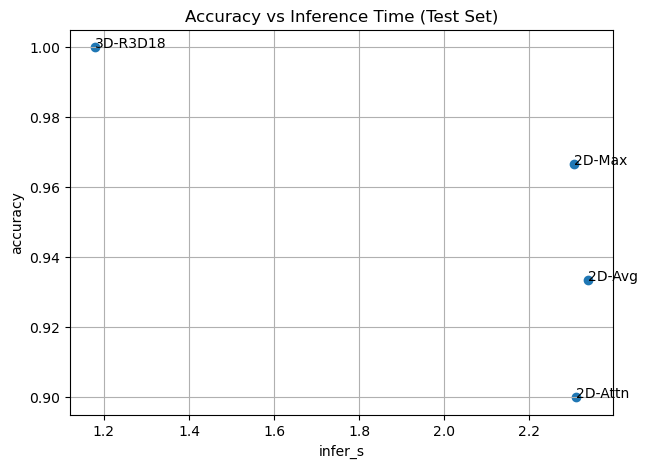


=== GPU Memory Usage ===
GPU memory max allocated: 1157.8 MB, reserved: 1600.0 MB


In [55]:
all_model_results = {}

#2D EfficientNet Models
print("\n=== Evaluating 2D EfficientNet Models ===")

# Average Pooling Model
print("\n--- 2D EfficientNet (Average Pooling) ---")
model_avg = EfficientNetTemporal(NUM_CLASSES, pooling="avg").to(DEVICE)
model_avg.load_state_dict(torch.load(best_avg, map_location=DEVICE))
y_true_avg, y_pred_avg, y_prob_avg, infer_time_avg = eval_deep_2d(model_avg, test_rows, batch=BATCH_2D)
report_all_metrics(y_true_avg, y_pred_avg, y_prob_avg, title="2D-Avg Pool")
acc_avg = accuracy_score(y_true_avg, y_pred_avg)
prec_avg, rec_avg, f1_avg, _ = precision_recall_fscore_support(y_true_avg, y_pred_avg, average="macro", zero_division=0)
all_model_results["2D-Avg"] = {"accuracy": acc_avg, "precision": prec_avg, "recall": rec_avg, "f1": f1_avg, "infer_s": infer_time_avg, "params": model_num_params(model_avg)}
summarize_deep_model(model_avg, "2D-Avg")

# Max Pooling Model
print("\n--- 2D EfficientNet (Max Pooling) ---")
model_max = EfficientNetTemporal(NUM_CLASSES, pooling="max").to(DEVICE)
model_max.load_state_dict(torch.load(best_max, map_location=DEVICE))
y_true_max, y_pred_max, y_prob_max, infer_time_max = eval_deep_2d(model_max, test_rows, batch=BATCH_2D)
report_all_metrics(y_true_max, y_pred_max, y_prob_max, title="2D-Max Pool")
acc_max = accuracy_score(y_true_max, y_pred_max)
prec_max, rec_max, f1_max, _ = precision_recall_fscore_support(y_true_max, y_pred_max, average="macro", zero_division=0)
all_model_results["2D-Max"] = {"accuracy": acc_max, "precision": prec_max, "recall": rec_max, "f1": f1_max, "infer_s": infer_time_max, "params": model_num_params(model_max)}
summarize_deep_model(model_max, "2D-Max")

# Attention Pooling Model
print("\n--- 2D EfficientNet (Attention Pooling) ---")
model_attn = EfficientNetTemporal(NUM_CLASSES, pooling="attn").to(DEVICE)
model_attn.load_state_dict(torch.load(best_att, map_location=DEVICE))
y_true_attn, y_pred_attn, y_prob_attn, infer_time_attn = eval_deep_2d(model_attn, test_rows, batch=BATCH_2D)
report_all_metrics(y_true_attn, y_pred_attn, y_prob_attn, title="2D-Attn Pool")
acc_attn = accuracy_score(y_true_attn, y_pred_attn)
prec_attn, rec_attn, f1_attn, _ = precision_recall_fscore_support(y_true_attn, y_pred_attn, average="macro", zero_division=0)
all_model_results["2D-Attn"] = {"accuracy": acc_attn, "precision": prec_attn, "recall": rec_attn, "f1": f1_attn, "infer_s": infer_time_attn, "params": model_num_params(model_attn)}
summarize_deep_model(model_attn, "2D-Attn")

#3D R3D-18 Model
print("\n=== Evaluating 3D R3D-18 Model ===")
model_3d = build_3d_model(NUM_CLASSES).to(DEVICE)
model_3d.load_state_dict(torch.load(best_3d, map_location=DEVICE))
y_true_3d, y_pred_3d, y_prob_3d, infer_time_3d = eval_deep_3d(model_3d, test_rows, batch=BATCH_3D)
report_all_metrics(y_true_3d, y_pred_3d, y_prob_3d, title="3D R3D-18")
acc_3d = accuracy_score(y_true_3d, y_pred_3d)
prec_3d, rec_3d, f1_3d, _ = precision_recall_fscore_support(y_true_3d, y_pred_3d, average="macro", zero_division=0)
all_model_results["3D-R3D18"] = {"accuracy": acc_3d, "precision": prec_3d, "recall": rec_3d, "f1": f1_3d, "infer_s": infer_time_3d, "params": model_num_params(model_3d)}
summarize_deep_model(model_3d, "3D-R3D18")

print("\n=== Overall Model Comparison ===")
compare_models_bar(all_model_results, "accuracy", "Accuracy Comparison (Test Set)")
compare_models_bar(all_model_results, "f1", "F1-Score Comparison (Test Set)")
compare_models_bar(all_model_results, "infer_s", "Inference Time per Video (s) (Test Set)")

tradeoff_plot(all_model_results, x_key="infer_s", y_key="accuracy", title="Accuracy vs Inference Time (Test Set)")

print("\n=== GPU Memory Usage ===")
gpu_memory_report()

### Feature Analysis: Attention visualization + t-SNE/UMAP

#### Attention visualization (for 2D attention pooling)

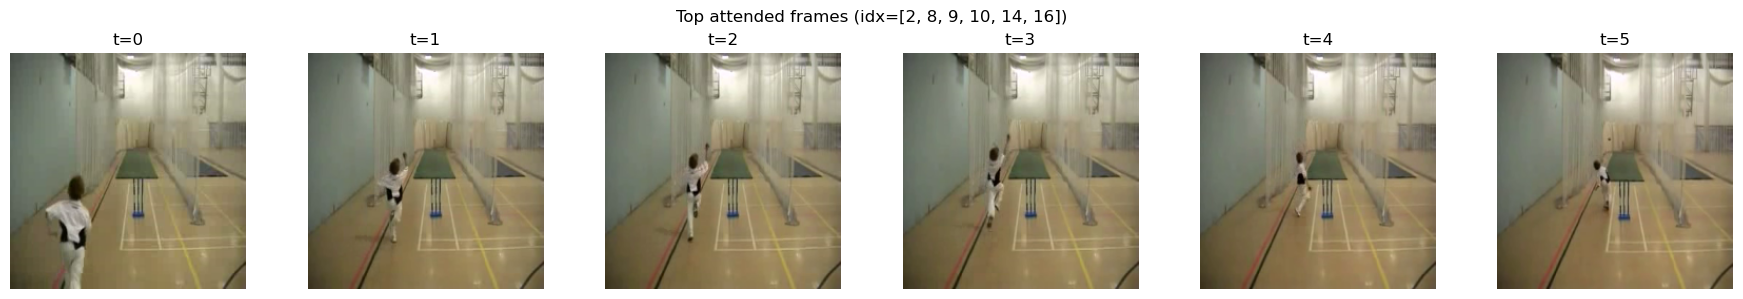

In [43]:
def visualize_attention_on_frames(frames_bgr, attn_weights, topk=6):
    # frames_bgr: list length T, attn_weights length T
    T = len(frames_bgr)
    attn = np.array(attn_weights)
    idxs = np.argsort(-attn)[:min(topk, T)]
    idxs = idxs[np.argsort(idxs)]  # keep chronological

    sel = [frames_bgr[i] for i in idxs]
    show_frame_grid(sel, n=len(sel), cols=len(sel), title=f"Top attended frames (idx={idxs.tolist()})")

# compute attn for one video and show top frames
model_attn.load_state_dict(torch.load("best_2d_attn.pt", map_location=DEVICE))
model_attn.eval()
rel, _ = val_rows[0]
abs_path = os.path.join(DATA_ROOT, rel)
frames = resize_frames(load_video_cv2(abs_path, max_frames=400), IMG_SIZE)
frames = uniform_sample(frames, 32)
x = torch.stack([imgnet_norm(transforms.ToTensor()(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))) for fr in frames]).unsqueeze(0)
x = x.to(DEVICE)
with torch.no_grad():
    _, attn = model_attn(x)
visualize_attention_on_frames(frames, attn[0].cpu().numpy(), topk=6)

#### t-SNE visualization of learned representations

Embeddings: 100%|██████████| 60/60 [02:19<00:00,  2.32s/it]


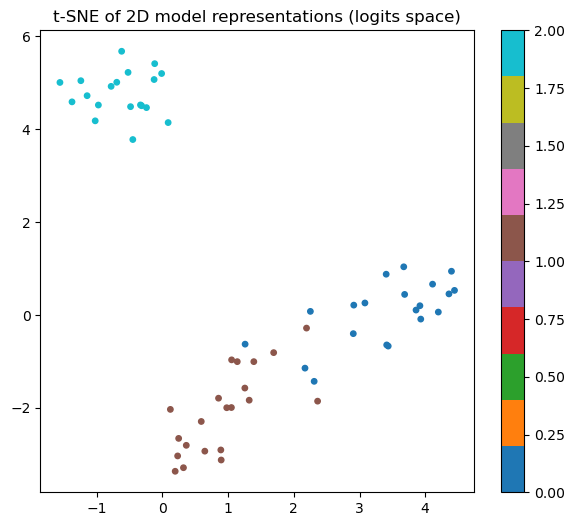

In [35]:
from sklearn.manifold import TSNE

@torch.no_grad()
def extract_embeddings_2d(model, rows, max_videos=200):
    ds = FrameDataset2D(rows, num_frames=32, sampling="uniform")
    dl = DataLoader(ds, batch_size=1, shuffle=False)

    # Gets embeddings before final FC: use model backbone + pooling
    model.eval()
    embs, labels = [], []

    for i, (x, y) in enumerate(tqdm(dl, desc="Embeddings")):
        x = x.to(DEVICE)
        logits, attn = model(x) 
     
        embs.append(logits.squeeze(0).cpu().numpy())
        labels.append(int(y.item()))
        if i+1 >= max_videos:
            break

    return np.array(embs), np.array(labels)

def plot_tsne(embs, labels, title="t-SNE"):
    ts = TSNE(n_components=2, perplexity=25, init="pca", random_state=42)
    z = ts.fit_transform(embs)
    plt.figure(figsize=(7,6))
    plt.scatter(z[:,0], z[:,1], c=labels, cmap="tab10", s=15)
    plt.colorbar()
    plt.title(title)
    plt.show()

model_avg = EfficientNetTemporal(NUM_CLASSES, pooling="avg").to(DEVICE)
model_avg.load_state_dict(torch.load("best_2d_avg.pt", map_location=DEVICE))
embs, labs = extract_embeddings_2d(model_avg, test_rows, max_videos=150)
plot_tsne(embs, labs, "t-SNE of 2D model representations (logits space)")

### Discussion: Deployment and Maintenance Considerations

#### 1. Which approach is more suitable for edge deployment?

**2D CNN + Temporal Pooling (EfficientNetTemporal):** This approach is generally more suitable for **edge deployment**.

*   **Reasoning:**
    *   **Lower Computational Cost:** 2D CNNs (like EfficientNet-B0) are typically lighter than 3D CNNs, requiring less computational power per frame.
    *   **Lower Memory Footprint:** The models tend to have fewer parameters and require less memory, which is crucial for resource-constrained edge devices.
    *   **Faster Inference:** Processing individual frames and then aggregating is generally faster than processing entire 3D clips, making it more viable for near real-time applications on edge hardware.
    *   **Flexibility in Frame Rate:** It can adapt more easily to varying video frame rates or irregular frame intervals, as it processes frames independently before pooling.

#### 2. Which approach is more suitable for cloud deployment?

**3D CNN (R3D-18):** This approach is more suitable for **cloud deployment**.

*   **Reasoning:**
    *   **Higher Computational Demands:** 3D CNNs operate on video clips as volumetric data (C, T, H, W), which is computationally intensive due to the extra temporal dimension. Cloud environments offer the scalable GPU resources needed to handle this.
    *   **Higher Memory Requirements:** These models typically have more parameters and require significantly more memory, which is readily available in cloud-based GPU instances.
    *   **Better Temporal Modeling:** 3D CNNs are designed to learn spatio-temporal features directly, which can lead to higher accuracy for complex actions or events that heavily rely on motion cues. 
    *   **Batch Processing:** Cloud infrastructure excels at handling large-batch processing, which can be highly efficient for 3D CNNs processing multiple video clips concurrently.

#### 3. Real-time processing feasibility

*   **2D CNN + Temporal Pooling:** This approach has **higher real-time processing feasibility**.
    *   The ability to process frames individually and then pool allows for lower latency if frame-by-frame processing is fast enough. The bottleneck would be the frame extraction and feature computation, but modern 2D CNNs are often optimized for speed.
    *   For applications where immediate response is critical (e.g., surveillance, simple gesture recognition), this model can be configured to process short sequences quickly.

*   **3D CNN:** Real-time processing is **more challenging but achievable** under certain conditions.
    *   Processing a full 3D clip (e.g., 16 frames) at once inherently introduces more latency than processing single frames. The entire clip must be buffered before inference can begin.
    *   Achieving real-time with 3D CNNs often requires powerful GPUs and careful optimization, potentially limiting the maximum frame rate or clip length that can be processed in real-time.
    *   It's more suited for scenarios where a slight delay is acceptable or where the 'real-time' definition is on the order of seconds rather than milliseconds (e.g., live sports analysis where a few seconds delay is fine).

#### 4. Maintenance and update considerations

*   **2D CNN + Temporal Pooling:**
    *   **Maintenance:** Easier due to simpler architecture and potentially larger community support for 2D image models. Updates to the 2D backbone (e.g., a newer EfficientNet variant) are often straightforward.
    *   **Data Handling:** Since it works on frames, handling varying video lengths, missing frames, or corrupted segments might be more robust, as individual frame issues are less likely to derail the entire sequence processing.
    *   **Model Size:** Smaller model sizes make deployment and updates faster, as new versions are quicker to download and deploy to edge devices.

*   **3D CNN:**
    *   **Maintenance:** Can be more complex. The specialized 3D convolutions require a deeper understanding of video data. Updates to 3D video models are less frequent compared to 2D image models, and the community for specific 3D architectures might be smaller.
    *   **Data Handling:** Requires consistent video clips of a specific length and frame rate. Issues like dropped frames or irregular sampling can be more problematic, requiring robust preprocessing pipelines.
    *   **Model Size:** Larger model sizes mean updates take longer to deploy, and rollback strategies need to account for larger binaries. Ensuring compatibility across different hardware versions in a distributed cloud environment can also be a consideration.